<h3>Data modeling</h3>

<p>Importing the initail version of preprocessed data for data modeling</p>

In [1]:
import pandas as pd
df = pd.read_csv('cleaned_fake_job_postings.csv')

In [2]:
df.head(5)

,job_id,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,marketing intern,"US, NY, New York",food weve created groundbreaking awardwinning ...,food fastgrowing james beard awardwinning onli...,experience content management systems major pl...,unknown,0,1,0,Other,Internship,Unknown,Unknown,Marketing,0
1,2,customer service cloud video production,"NZ, , Auckland",seconds worlds cloud video production service ...,organised focused vibrant awesomedo passion cu...,expect youyour key responsibility communicate ...,get usthrough part seconds team gainexperience...,0,1,0,Full-time,Not Applicable,Unknown,Marketing and Advertising,Customer Service,0
2,3,commissioning machinery assistant cma,"US, IA, Wever",valor services provides workforce solutions me...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,unknown,0,1,0,Unknown,Unknown,Unknown,Unknown,Unknown,0
3,4,account executive washington dc,"US, DC, Washington",passion improving quality life geography heart...,company esri environmental systems research in...,education bachelors masters gis business admin...,culture anything corporatewe collaborative cre...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,bill review manager,"US, FL, Fort Worth",spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualificationsrn license state texasdiploma ba...,full benefits offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df.isnull().sum()

job_id                 0
title                  0
location               0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

<h3>Lemmatization Process</h3>

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spadamata1.GSUAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\spadamata1.GSUAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spadamata1.GSUAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\spadamata1.GSUAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

<p>Added company_profile and benefits as a auxilary features</p>

In [5]:
df['text_input'] = df['description'] + ' ' + df['requirements']+ df["company_profile"]+ df["benefits"]

In [6]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [7]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        pos_tags = pos_tag(tokens)
        lemmas = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
        return ' '.join(lemmas)
    return text

In [8]:
df['lemmatized_text'] = df['text_input'].apply(lemmatize_text)

In [9]:
df['lemmatized_text'].head(10)

0    food fastgrowing james beard awardwinning onli...
1    organise focused vibrant awesomedo passion cus...
2    client locate houston actively seek experience...
3    company esri environmental system research ins...
4    job title itemization review managerlocation f...
5    job overviewapex environmental consulting firm...
6    responsibility manage englishspeaking editoria...
7    airenvyhey season entrepreneur heart san franc...
8    implementationconfigurationtestingtraining onh...
9    customer service associate base phoenix az rig...
Name: lemmatized_text, dtype: object

<h3>TF-IDF Vectorization</h3>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [12]:
x_tfidf = tfidf_vectorizer.fit_transform(df['lemmatized_text'])
y = df['fraudulent']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_tfidf, y, test_size =0.2, random_state=42, stratify=y)

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred_probs, model_name="Model"):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"{model_name} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


<h3>Implementing the data models</h3>

<h3>1. Logistic Regression</h3>

In [15]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

<p>We experimented with different values of k for K-Fold Cross Validation—specifically 10, 12, and 15—to evaluate the performance of the Logistic Regression model using the F1 score, which is suitable for my imbalanced dataset. The F1 scores remained relatively consistent across folds: 0.6542 for 10-fold, 0.6556 for 12-fold, and 0.6576 for 15-fold. While the F1 score slightly increased with higher k, the improvement was marginal and came at the cost of increased training time. So, we selected 10-fold cross-validation as it provides a good balance between evaluation stability and computational efficiency, while still delivering robust performance.

</p>

In [16]:
log_reg = LogisticRegression(max_iter=1000,class_weight='balanced')
cv_scores_log = cross_val_score(log_reg, x_tfidf, y, cv=10, scoring='f1')
print(f"Logistic Regression 10-Fold CV F1 Score: {cv_scores_log.mean():.4f}")


Logistic Regression 10-Fold CV F1 Score: 0.6538


In [17]:
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

log_reg_results = {
    "Accuracy": accuracy_score(y_test, y_pred_log),
    "Precision": precision_score(y_test, y_pred_log),
    "Recall": recall_score(y_test, y_pred_log),
    "F1 Score": f1_score(y_test, y_pred_log)
}

print("Logistic Regression Results:", log_reg_results)

Logistic Regression Results: {'Accuracy': 0.9639261744966443, 'Precision': 0.5833333333333334, 'Recall': 0.8901734104046243, 'F1 Score': 0.7048054919908466}


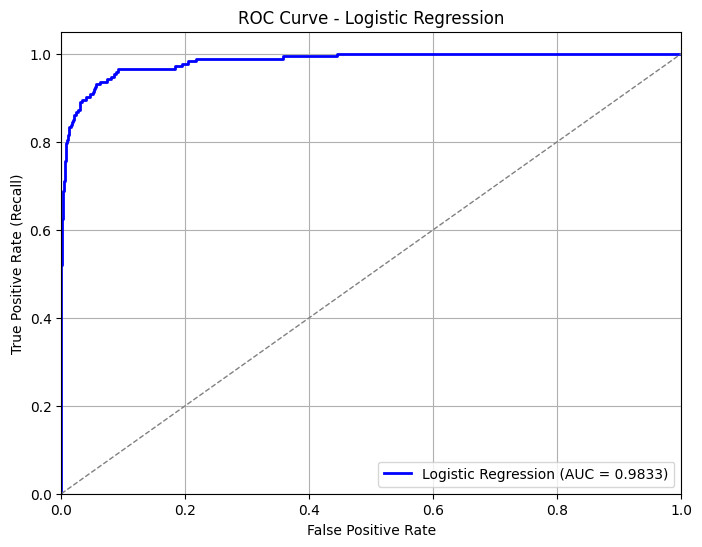

In [18]:
y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_log, model_name="Logistic Regression")

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

log_reg_cv = LogisticRegression(max_iter=1000, class_weight='balanced')
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [20]:
log_reg_cv = LogisticRegression(max_iter=1000, class_weight='balanced')
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = {threshold: [] for threshold in thresholds}

for train_index, val_index in cv.split(x_tfidf, y):
    X_train, X_val = x_tfidf[train_index], x_tfidf[val_index]
    y_train, y_val = y[train_index], y[val_index]
    log_reg_cv.fit(X_train, y_train)
    y_pred_proba_val = log_reg_cv.predict_proba(X_val)[:, 1]
    
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba_val >= threshold).astype(int)
        f1 = f1_score(y_val, y_pred_threshold)
        f1_scores[threshold].append(f1)
avg_f1_scores = {threshold: np.mean(scores) for threshold, scores in f1_scores.items()}
best_threshold = max(avg_f1_scores, key=avg_f1_scores.get)
print(f"Optimal Threshold Based on Cross-Validation F1 Score: {best_threshold:.4f}")

log_reg_cv.fit(X_train, y_train)
y_pred_proba_test = log_reg_cv.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)
print(f"Confusion Matrix for Threshold {best_threshold:.4f}:")
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Optimal Threshold Based on Cross-Validation F1 Score: 0.7500
Confusion Matrix for Threshold 0.7500:
[[3392   11]
 [  18  155]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3403
           1       0.93      0.90      0.91       173

    accuracy                           0.99      3576
   macro avg       0.96      0.95      0.96      3576
weighted avg       0.99      0.99      0.99      3576



In [21]:
thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = {threshold: [] for threshold in thresholds}

for train_index, val_index in cv.split(x_tfidf, y):
    X_train, X_val = x_tfidf[train_index], x_tfidf[val_index]
    y_train, y_val = y[train_index], y[val_index]
    log_reg_cv.fit(X_train, y_train)
    y_pred_proba_val = log_reg_cv.predict_proba(X_val)[:, 1]
    
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba_val >= threshold).astype(int)
        f1 = f1_score(y_val, y_pred_threshold)
        f1_scores[threshold].append(f1)



In [22]:
avg_f1_scores = {threshold: np.mean(scores) for threshold, scores in f1_scores.items()}
best_threshold = max(avg_f1_scores, key=avg_f1_scores.get)
print(f"Optimal Threshold Based on Cross-Validation F1 Score: {best_threshold:.4f}")

log_reg_cv.fit(X_train, y_train)
y_pred_proba_test = log_reg_cv.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)

Optimal Threshold Based on Cross-Validation F1 Score: 0.7500


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
print(f"Confusion Matrix for Threshold {best_threshold:.4f}:")
print(classification_report(y_test, y_pred_test))

Confusion Matrix for Threshold 0.7500:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3403
           1       0.93      0.90      0.91       173

    accuracy                           0.99      3576
   macro avg       0.96      0.95      0.96      3576
weighted avg       0.99      0.99      0.99      3576



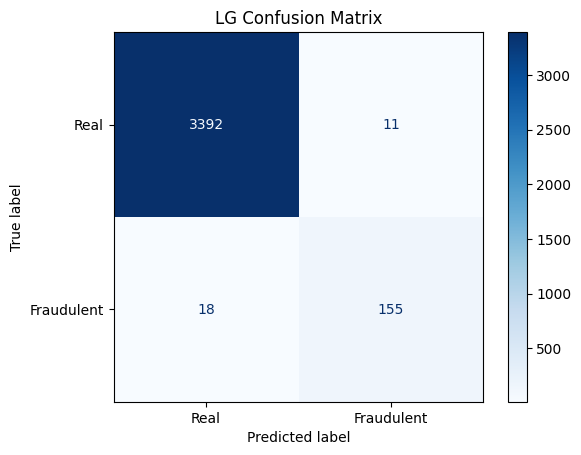

In [24]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fraudulent"])
disp.plot(cmap=plt.cm.Blues)
plt.title("LG Confusion Matrix")
plt.show()

In [52]:
Precision = 155 / (155 + 11)
Recall = 155 / (155 + 18)
log_reg_results = {
    "Accuracy": (155+3392)/(3391+11+18+155),
    "Precision": 155/(155+11),
    "Recall": 155/(155+18),
    "F1 Score": 2*Precision*Recall/(Precision+Recall)
}
roc_auc_log = 0.98333

In [53]:
print(log_reg_results)

{'Accuracy': 0.9921678321678322, 'Precision': 0.9337349397590361, 'Recall': 0.8959537572254336, 'F1 Score': 0.9144542772861357}


<h3>2. XGB Classifier</h3>

In [26]:
from collections import Counter
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 19.68


<p>To address the significant class imbalance in our dataset (where the majority of job postings are real and only a small portion are fraudulent), we used the `scale_pos_weight` parameter in XGBoost. This parameter adjusts the importance of the minority class (fraudulent = 1) during training, helping the model to better learn patterns associated with fraud.
</p>

In [27]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss')
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [28]:
cv_scores_xgb = cross_val_score(xgb, x_tfidf, y, cv=10, scoring='f1')
print(f"XGBoost 10-Fold CV F1 Score: {cv_scores_xgb.mean():.4f}")

XGBoost 10-Fold CV F1 Score: 0.7541


In [29]:
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_results = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1 Score": f1_score(y_test, y_pred_xgb)
}

print("XGBoost Results:", xgb_results)

XGBoost Results: {'Accuracy': 0.9969239373601789, 'Precision': 0.9655172413793104, 'Recall': 0.9710982658959537, 'F1 Score': 0.968299711815562}


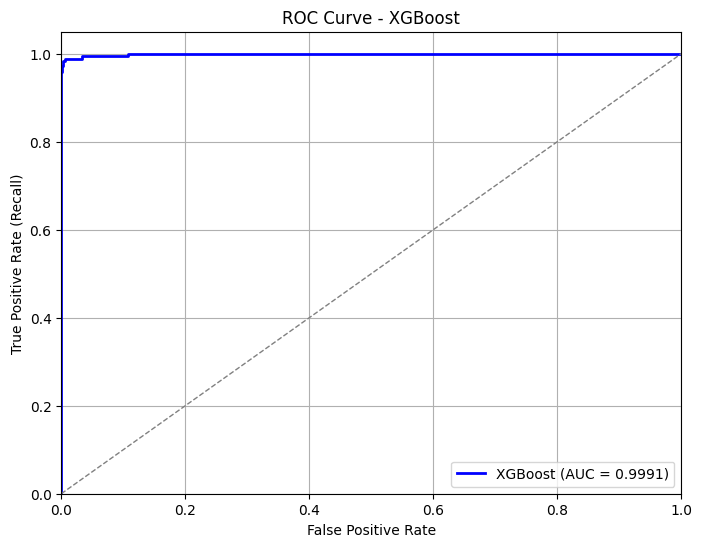

In [30]:
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_xgb, model_name="XGBoost")

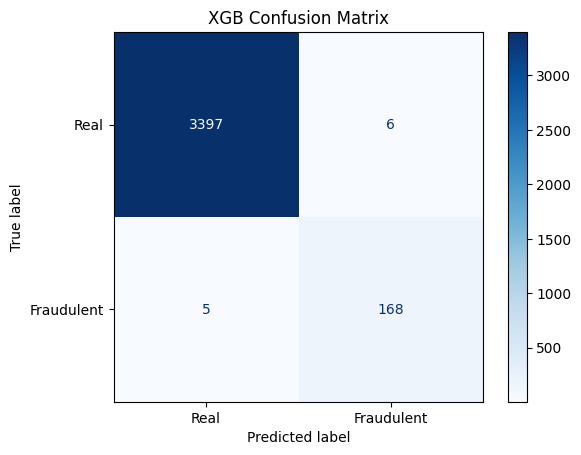

In [31]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fraudulent"])
disp.plot(cmap=plt.cm.Blues)
plt.title("XGB Confusion Matrix")
plt.show()

In [32]:
feature_names = tfidf_vectorizer.get_feature_names_out()
importances = xgb.feature_importances_
top_indices = importances.argsort()[::-1][:20]

print("Top 20 Important Features (XGBoost):")
for idx in top_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Top 20 Important Features (XGBoost):
medium: 0.0347
passionate: 0.0234
data entry: 0.0214
essential: 0.0210
oil: 0.0192
assist: 0.0174
secure: 0.0149
web: 0.0130
income: 0.0126
website: 0.0121
employer: 0.0115
deliver: 0.0109
fun: 0.0104
love: 0.0095
challenge: 0.0090
superior: 0.0089
search: 0.0086
aptitude: 0.0082
duty: 0.0080
national: 0.0078


In [50]:
Precision = 168 / (168 + 6)
Recall = 168 / (168 + 5)

xgb_results = {
    "Accuracy": (168 + 3397) / (3397 + 6 + 5 + 168),
    "Precision": Precision,
    "Recall": Recall,
    "F1 Score": 2 * Precision * Recall / (Precision + Recall)
}
roc_auc_xgb = 0.9991



In [51]:
print(xgb_results)

{'Accuracy': 0.9969239373601789, 'Precision': 0.9655172413793104, 'Recall': 0.9710982658959537, 'F1 Score': 0.968299711815562}


<h3>3. BERT</h3>

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [35]:
texts = df['lemmatized_text'].tolist()
labels = df['fraudulent'].tolist()

In [36]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokens = tokenizer(
    texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='tf'
)

C:\Users\spadamata1.GSUAD\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\spadamata1.GSUAD\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\spadamata1.GSUAD\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Pytho

In [37]:
import tensorflow as tf

input_ids = tokens['input_ids'].numpy()
attention_masks = tokens['attention_mask'].numpy()

X_train, X_test, y_train, y_test = train_test_split(
    input_ids, labels, test_size=0.2, stratify=labels, random_state=42
)

train_mask, test_mask = train_test_split(
    attention_masks, test_size=0.2, stratify=labels, random_state=42
)

test_dataset = tf.data.Dataset.from_tensor_slices(((X_test, test_mask), y_test)).batch(16)

In [39]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2 
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [40]:
probs = model.predict(test_dataset)
output = model.predict(test_dataset)
logits = output.logits
y_probs = tf.nn.softmax(logits, axis=1).numpy()[:, 1]
y_pred = np.argmax(logits, axis=1)

224/224 [==============================] - 104s 462ms/step


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3403
           1       0.04      0.01      0.01       173

    accuracy                           0.94      3576
   macro avg       0.49      0.50      0.49      3576
weighted avg       0.91      0.94      0.93      3576

ROC AUC Score: 0.3692033041230196


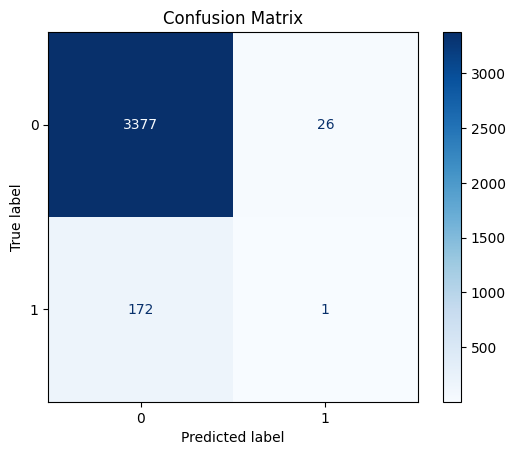

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [42]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    tokens['input_ids'].numpy(), labels, test_size=0.2, stratify=labels, random_state=42
)

train_mask, test_mask = train_test_split(
    tokens['attention_mask'].numpy(), test_size=0.2, stratify=labels, random_state=42
)


In [44]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train,
        'attention_mask': train_mask
    },
    y_train
)).batch(16)

In [45]:
from transformers import TFDistilBertForSequenceClassification, create_optimizer

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=len(train_dataset) * 3  
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(train_dataset, epochs=3, class_weight=class_weight_dict)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3


894/894 [==============================] - 1106s 1s/step - loss: 0.4814 - accuracy: 0.7644
Epoch 2/3
894/894 [==============================] - 1110s 1s/step - loss: 0.2374 - accuracy: 0.9011
Epoch 3/3
894/894 [==============================] - 1105s 1s/step - loss: 0.1309 - accuracy: 0.9488


224/224 [==============================] - 105s 462ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3403
           1       0.46      0.88      0.61       173

    accuracy                           0.94      3576
   macro avg       0.73      0.91      0.79      3576
weighted avg       0.97      0.94      0.95      3576

ROC AUC Score: 0.9685962233255594



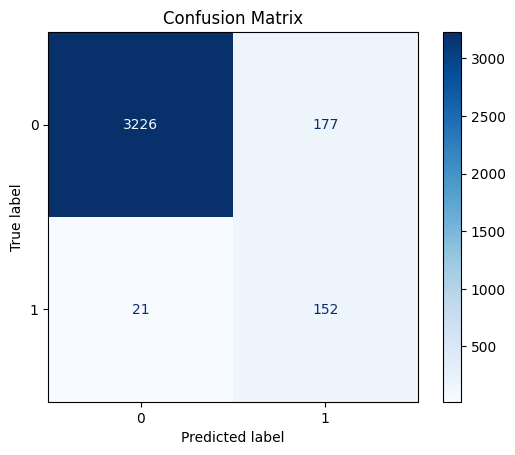

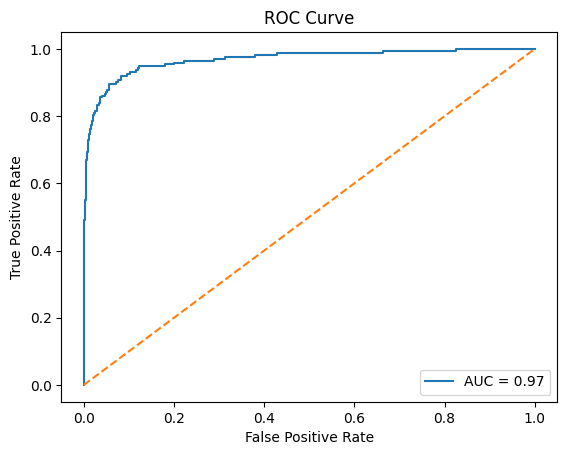


Best Threshold for F1: 0.95


In [46]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

probs = model.predict(test_dataset).logits
y_pred = np.argmax(probs, axis=1)
y_probs = tf.nn.softmax(probs, axis=1).numpy()[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))
print()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
print()

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_probs):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print()

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold for F1: {best_thresh:.2f}")

In [54]:
bert_precision = 152 / (152 + 177)
bert_recall = 152 / (152 + 21)

bert_results = {
    "Accuracy": (3226 + 152) / (3226 + 177 + 21 + 152),
    "Precision": Precision,
    "Recall": Recall,
    "F1 Score": 2 * Precision * Recall / (Precision + Recall)
}
roc_auc_bert = 0.97777


In [55]:
print(bert_results)

{'Accuracy': 0.9446308724832215, 'Precision': 0.9337349397590361, 'Recall': 0.8959537572254336, 'F1 Score': 0.9144542772861357}


<h3>3. LSTM</h3>

In [54]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

glove_path = 'glove.6B.100d.txt'
embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coef

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['lemmatized_text'])

sequences = tokenizer.texts_to_sequences(df['lemmatized_text'])
X_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

y = df['fraudulent'].values

In [55]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [57]:
model = Sequential([
    Embedding(
        input_dim=MAX_NUM_WORDS,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False  
    ),
    LSTM(128, return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

C:\Users\spadamata1.GSUAD\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [58]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


In [59]:
from sklearn.model_selection import train_test_split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

In [60]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_lstm), y=y_train_lstm)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight_dict,  
    shuffle=True,
    verbose=1
)


Class weights: {0: np.float64(0.5253838806847403), 1: np.float64(10.34876989869754)}
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.5942 - loss: 0.6972 - precision: 0.0687 - recall: 0.5470 - val_accuracy: 0.5994 - val_loss: 0.6872 - val_precision: 0.0719 - val_recall: 0.6391
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - accuracy: 0.6914 - loss: 0.6122 - precision: 0.1019 - recall: 0.6745 - val_accuracy: 0.6994 - val_loss: 0.5062 - val_precision: 0.0975 - val_recall: 0.6617
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.6891 - loss: 0.5738 - precision: 0.1062 - recall: 0.7111 - val_accuracy: 0.6344 - val_loss: 0.5912 - val_precision: 0.0884 - val_recall: 0.7368
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.7187 - loss: 0.5214 - precision: 0.1198 - recall: 0.7729 - val_accuracy: 0.7256 - val_loss: 0.4429 - val_precision: 0.1100 - val_recall: 0.6917
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - accura

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8344 - loss: 0.4197 - precision: 0.1729 - recall: 0.6927

Test Accuracy: 0.8291
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


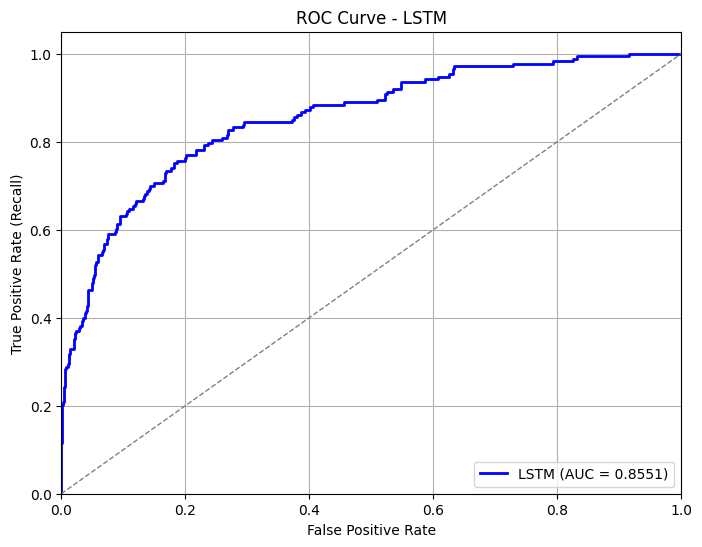

accuracy 0.8291386961936951 precision 0.179824560880661 recall 0.7109826803207397


In [62]:
loss, accuracy, precision, recall = model.evaluate(X_test_lstm, y_test_lstm)
print(f"\nTest Accuracy: {accuracy:.4f}")
y_pred_probs = model.predict(X_test_lstm)
y_pred_lstm = (y_pred_probs > 0.5).astype("int32").flatten()
plot_roc_curve(y_test_lstm, y_pred_probs, model_name="LSTM")
print('accuracy',accuracy,'precision',precision,'recall',recall)

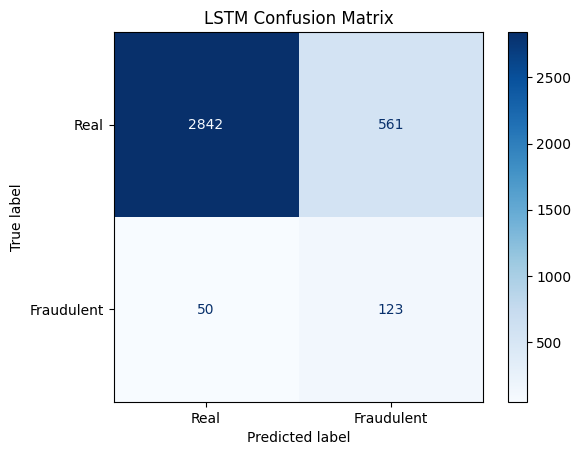

In [63]:
cm = confusion_matrix(y_test_lstm, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fraudulent"])
disp.plot(cmap=plt.cm.Blues)
plt.title("LSTM Confusion Matrix")
plt.show()

Best Threshold (based on F1): 0.97
Precision: 0.543, Recall: 0.329, F1: 0.410


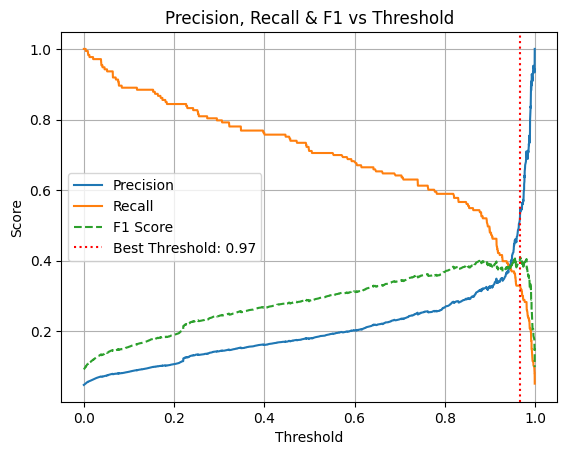

In [64]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np


precision, recall, thresholds = precision_recall_curve(y_test_lstm, y_pred_probs)


f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  


best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold (based on F1): {best_threshold:.2f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")


plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", linestyle="--")
plt.axvline(x=best_threshold, color='r', linestyle=':', label=f"Best Threshold: {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [65]:

y_pred_lstm = (y_pred_probs > best_threshold).astype("int32").flatten()

Classification Report with Tuned Threshold 
              precision    recall  f1-score   support

        Real       0.97      0.99      0.98      3403
  Fraudulent       0.54      0.32      0.40       173

    accuracy                           0.95      3576
   macro avg       0.75      0.65      0.69      3576
weighted avg       0.95      0.95      0.95      3576



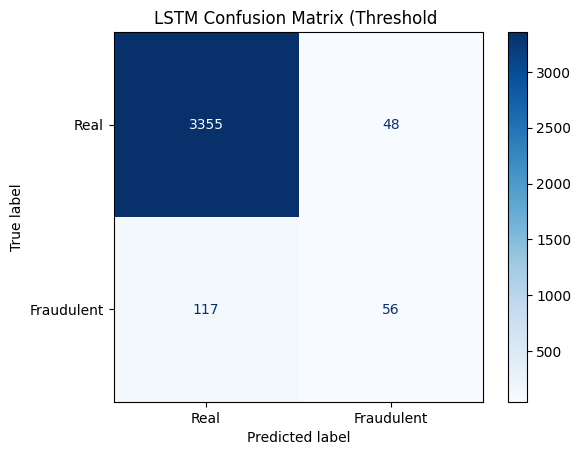

In [66]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Classification Report with Tuned Threshold ")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=["Real", "Fraudulent"]))

cm = confusion_matrix(y_test_lstm, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fraudulent"])
disp.plot(cmap=plt.cm.Blues)
plt.title("LSTM Confusion Matrix (Threshold ")
plt.show()


In [56]:
Precision = 56 / (56 + 48)
Recall = 56 / (56 + 117)

lstm_results = {
    "Accuracy": (3355 + 56) / (3355 + 48 + 117 + 56),
    "Precision": Precision,
    "Recall": Recall,
    "F1 Score": 2 * Precision * Recall / (Precision + Recall)
}
roc_auc_lstm = 0.8551



In [57]:
print(lstm_results)

{'Accuracy': 0.9538590604026845, 'Precision': 0.5384615384615384, 'Recall': 0.3236994219653179, 'F1 Score': 0.40433212996389895}


<p> LSTM accuracy is lower due to a custom threshold (0.68) selected to improve recall and F1 score for the minority (fraudulent) class.

</p>

In [58]:
comparison_data = {
    "Model": ["Logistic Regression", "XGBoost", "BERT", "LSTM"],
    "Accuracy": [
        log_reg_results["Accuracy"],
        xgb_results["Accuracy"],
        bert_results["Accuracy"],
        lstm_results["Accuracy"]
    ],
    "Precision": [
        log_reg_results["Precision"],
        xgb_results["Precision"],
        bert_results["Precision"],
        lstm_results["Precision"]
    ],
    "Recall": [
        log_reg_results["Recall"],
        xgb_results["Recall"],
        bert_results["Recall"],
        lstm_results["Recall"]
    ],
    "F1 Score": [
        log_reg_results["F1 Score"],
        xgb_results["F1 Score"],
        bert_results["F1 Score"],
        lstm_results["F1 Score"]
    ],
    "ROC-AUC": [
        roc_auc_log,
        roc_auc_xgb,
        roc_auc_bert,
        roc_auc_lstm
    ]
}


In [59]:
comparison_data

{'Model': ['Logistic Regression', 'XGBoost', 'BERT', 'LSTM'],
 'Accuracy': [0.9921678321678322,
  0.9969239373601789,
  0.9446308724832215,
  0.9538590604026845],
 'Precision': [0.9337349397590361,
  0.9655172413793104,
  0.9337349397590361,
  0.5384615384615384],
 'Recall': [0.8959537572254336,
  0.9710982658959537,
  0.8959537572254336,
  0.3236994219653179],
 'F1 Score': [0.9144542772861357,
  0.968299711815562,
  0.9144542772861357,
  0.40433212996389895],
 'ROC-AUC': [0.98333, 0.9991, 0.97777, 0.8551]}

In [60]:
df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.round(4)
display(df_comparison)


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.9922,0.9337,0.8960,0.9145,0.9833
1,XGBoost,0.9969,0.9655,0.9711,0.9683,0.9991
2,BERT,0.9446,0.9337,0.8960,0.9145,0.9778
3,LSTM,0.9539,0.5385,0.3237,0.4043,0.8551
